In [1]:
import math
import numpy as np

import scipy
import scipy.io
import scipy.signal

import os

import matplotlib
import matplotlib.pyplot as plt


import sklearn
import sklearn.preprocessing

import h5py

import torch
import torch.nn as nn

from tqdm.notebook import tqdm as tqdm_notebook

from torch.utils.tensorboard import SummaryWriter


def data_generator(X, Y, batch_size, lag_backward, lag_forward, shuffle=True, infinite=True):
    assert len(X)==len(Y) or len(Y)==0
    total_lag = lag_backward + lag_forward
    all_batches = math.ceil((X.shape[0] - total_lag) /batch_size)
    samples_in_last_batch = (X.shape[0] - total_lag) % batch_size
    batch = 0
    random_core = np.arange(lag_backward, X.shape[0]-lag_forward)
    while True:
        if shuffle: np.random.shuffle(random_core)
        for batch in range(all_batches):       
            batch_start = batch * batch_size
            batch_end = (batch + 1) * batch_size
            if batch_end>=len(random_core): batch_end = None
            batch_samples = random_core[batch_start : batch_end]

            batch_x = np.array([X[i - lag_backward : i + lag_forward] for i in batch_samples])
            batch_x = np.swapaxes(batch_x,1,2)

            if len(Y) > 0:
                batch_y = Y[[batch_samples]] 
                yield (batch_x, batch_y)
            else:
                yield batch_x
        
        if not infinite:
            break

In [3]:
DATA_FOLDER = '/home/pet67/ossadtchi/datasets/bioelectric_lab/speech_ecog_procenko/Procenko'

FILES_LIST = [
#     f'{DATA_FOLDER}/10_03_2021/Patient001_test0012021.03.10_20.29.47.hdf5',
#     f'{DATA_FOLDER}/10_03_2021/Patient001_test0032021.03.10_20.40.15.hdf5',

    f'{DATA_FOLDER}/11_03_2021/Patient001_test0042021.03.11_19.12.59.hdf5',
    f'{DATA_FOLDER}/11_03_2021/Patient001_test0052021.03.11_19.26.24.hdf5',
    f'{DATA_FOLDER}/11_03_2021/Patient001_test0062021.03.11_19.42.41.hdf5',
    f'{DATA_FOLDER}/11_03_2021/Patient001_test0072021.03.11_20.40.02.hdf5',
    f'{DATA_FOLDER}/11_03_2021/Patient001_test0082021.03.11_20.55.25.hdf5',
    f'{DATA_FOLDER}/11_03_2021/Patient001_test0092021.03.11_21.10.53.hdf5',

]

def norch_filtering(ecog, frequency):
    ecog_filtered = ecog
    for w0 in [50, 100, 150]:
        norch_b, norch_a = scipy.signal.iirnotch(50, Q=10, fs=frequency)
        ecog_filtered = scipy.signal.filtfilt(norch_b, norch_a, ecog_filtered, axis=0)
    return ecog_filtered

def extract_sound_log_envelope(sound, frequency):
    LOW_PASS_FREQUENCY = 200
    HIGH_PASS_FREQUENCY = 200
    blp, alp = scipy.signal.butter(3, LOW_PASS_FREQUENCY / (frequency / 2), btype='low', analog=False)
    bhp, ahp = scipy.signal.butter(5, HIGH_PASS_FREQUENCY / (frequency / 2), btype='high', analog=False)

    sound_filtered  = scipy.signal.filtfilt(bhp, ahp, sound);
    envelope = scipy.signal.filtfilt(blp, alp, np.log(np.abs(sound_filtered)))
    return envelope

def envelope_signals(signals):
    enveloped_signals = np.zeros(signals.shape)
    for i in range(signals.shape[1]):
        enveloped_signals[:, i] = np.abs(scipy.signal.hilbert(signals[:, i]))
    return enveloped_signals


def remove_eyes_artifacts(ecog, frequency):
    HIGH_PASS_FREQUENCY = 20
    bgamma, agamma = scipy.signal.butter(5, HIGH_PASS_FREQUENCY / (frequency / 2), btype='high')
    return scipy.signal.filtfilt(bgamma, agamma, ecog, axis=0)


FREQUENCY = 19200
DOWNSAMPLING_COEF = 10

X = []
Y = []

for filepath in tqdm_notebook(FILES_LIST):
    with h5py.File(filepath,'r+') as input_file:
        data = input_file['RawData']['Samples'][()]
        
    ecog = data[:, :30].astype("double")
    sound = data[:, 31].astype("double")
    
    ecog /= np.max(np.abs(ecog)) # to avoid numerical problems
    sound /= np.max(np.abs(sound)) # to avoid numerical problems
    
    ecog = sklearn.preprocessing.scale(ecog, copy=False)
    sound = sklearn.preprocessing.scale(sound, copy=False)

    ecog = norch_filtering(ecog, FREQUENCY)

    sound_envelope = extract_sound_log_envelope(sound, FREQUENCY)

    ecog = scipy.signal.decimate(ecog, DOWNSAMPLING_COEF, axis=0)
    sound = scipy.signal.decimate(sound, DOWNSAMPLING_COEF, axis=0)
    sound_envelope = scipy.signal.decimate(sound_envelope, DOWNSAMPLING_COEF, axis=0)

    ecog = remove_eyes_artifacts(ecog, int(FREQUENCY / DOWNSAMPLING_COEF))

    X.append(ecog)
    Y.append(sound_envelope)

X = np.concatenate(X)
Y = np.concatenate(Y).reshape((-1, 1))

X = sklearn.preprocessing.scale(X, copy=False)
Y = sklearn.preprocessing.scale(Y, copy=False)

X = X.astype("float32")
Y = Y.astype("float32")

FREQUENCY = int(FREQUENCY / DOWNSAMPLING_COEF)

  0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
assert X.shape[0] == Y.shape[0]

print(f"{round(X.shape[0] / FREQUENCY / 60, 1)} min")

ntr = int(X.shape[0] * 0.80)

X_test = X[ntr:]
Y_test = Y[ntr:]

X_train = X[:ntr]
Y_train = Y[:ntr]

62.5 min


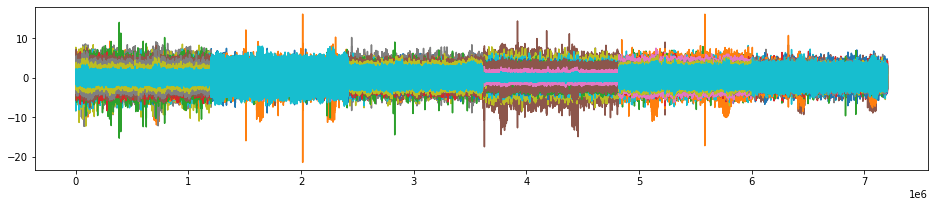

In [9]:
plt.figure(figsize=(16, 3))
plt.plot(X)
plt.show()

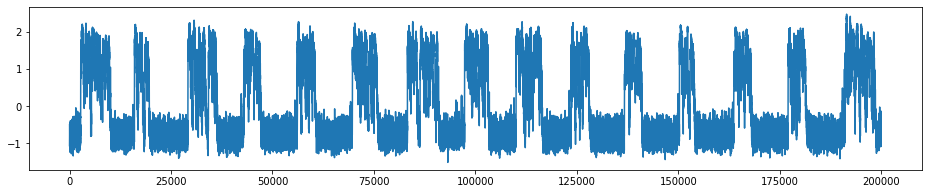

In [14]:
plt.figure(figsize=(16, 3))
plt.plot(Y[5_000_000:5_200_000])
plt.show()

In [15]:
class EnvelopeDetector(nn.Module):
    def __init__(self, in_channels, channels_per_channel):
        super(self.__class__,self).__init__()
        self.FILTERING_SIZE = 100
        self.ENVELOPE_SIZE = 50
        self.conv_filtering = nn.Conv1d(in_channels, self.in_channels, bias=False, kernel_size=self.FILTERING_SIZE, groups=in_channels)
        self.conv_envelope = nn.Conv1d(self.in_channels, self.in_channels, kernel_size=self.ENVELOPE_SIZE, groups=self.in_channels)
        self.pre_envelope_batchnorm = torch.nn.BatchNorm1d(self.in_channels, affine=False) 
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_filtering(x)
        x = self.pre_envelope_batchnorm(x)
        #x = self.relu(x)
        x = torch.abs(x)
        x = self.conv_envelope(x)
        return x


class SimpleNet(nn.Module):
    def __init__(self, in_channels, output_channels, lag_backward, lag_forward):
        super(self.__class__,self).__init__()
        self.ICA_CHANNELS = 5

        self.total_input_channels = self.ICA_CHANNELS
        self.lag_backward = lag_backward
        self.lag_forward = lag_forward

        self.final_out_features = 930 

        self.ica = nn.Conv1d(in_channels, self.ICA_CHANNELS, 1)

        self.detector = EnvelopeDetector(self.ICA_CHANNELS)
        self.unmixed_batchnorm = torch.nn.BatchNorm1d(self.ICA_CHANNELS, affine=False)
        
        self.features_batchnorm = torch.nn.BatchNorm1d(self.final_out_features, affine=False)
        

        self.wights_second = nn.Linear(self.final_out_features, output_channels)

    def forward(self, inputs):
        all_inputs = self.ica(inputs)
        #self.unmixed_channels = all_inputs.cpu().data.numpy()
        all_inputs = self.unmixed_batchnorm(all_inputs)

        detected_envelopes = self.detector(all_inputs)

        features  = detected_envelopes[:, :, ::10].contiguous()
        features = features.view(features.size(0), -1)
        features = self.features_batchnorm(features)
        #self.pre_out = features.cpu().data.numpy()
        output = self.wights_second(features)
        return output


In [19]:
writer = SummaryWriter()

LAG_BACKWARD = 1000
LAG_FORWARD = 1000


BATCH_SIZE = 100

model = SimpleNet(X_train.shape[1], Y_train.shape[1], LAG_BACKWARD, LAG_FORWARD).cuda()

print("Trainable params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total params: ",sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

train_generator = data_generator(X_train, Y_train, BATCH_SIZE, LAG_BACKWARD, LAG_FORWARD, shuffle=True, infinite=True)
test_generator = data_generator(X_test, Y_test, BATCH_SIZE, LAG_BACKWARD, LAG_FORWARD, shuffle=True, infinite=True)

loss_history_train = []
loss_history_test = []

def process_batch(generator, is_train):
    if is_train:
        model.train()
    else:
        model.eval()

    x_batch, y_batch = next(generator)
    assert x_batch.shape[0] == y_batch.shape[0]
    assert y_batch.shape[1] == 1
    #assert x_batch.shape[1] == 30
    x_batch = torch.FloatTensor(x_batch).cuda()
    y_batch = torch.FloatTensor(y_batch).cuda()

    if is_train:
        optimizer.zero_grad()

    y_predicted = model(x_batch)
    loss = loss_function(y_predicted, y_batch)

    if is_train:
        loss.backward()
        optimizer.step()


    assert y_predicted.shape[0] == y_batch.shape[0]
    assert y_predicted.shape[1] == y_batch.shape[1] == 1
    
    train_or_test = "train" if is_train else "test"

    correlation = np.corrcoef(y_predicted.cpu().detach().numpy(), y_batch.cpu().detach().numpy(), rowvar=False)[0, 1]

    writer.add_scalar(f'{train_or_test}/loss', loss.cpu().detach().numpy(), iteration)
    writer.add_scalar(f'{train_or_test}/correlation', correlation, iteration)
    
    if is_train:
        loss_history_train.append(correlation)
    else:
        loss_history_test.append(correlation)

    
for iteration in tqdm_notebook(range(30_000)):
    process_batch(train_generator, True)
    with torch.no_grad():
        process_batch(test_generator, False)
        
    if iteration % 250 == 0:
        eval_lag = min(1000, iteration)
        print(f"Train loss: {np.mean(loss_history_train[-eval_lag:])}")
        print(f"Train loss: {np.mean(loss_history_test[-eval_lag:])}")
        print("#")
        
    if iteration % 5000 == 0:
        torch.save(model.state_dict(), "speech_net")

Trainable params:  1841
Total params:  1841


  0%|          | 0/30000 [00:00<?, ?it/s]

/home/pet67/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Train loss: -0.011034515477374114
Train loss: -0.021347593137154418
#
Train loss: 0.1504088259254633
Train loss: 0.15050493747280488
#
Train loss: 0.3225345815356933
Train loss: 0.3521617595593686
#
Train loss: 0.39923429950529776
Train loss: 0.4391711091476186
#


KeyboardInterrupt: 

0it [00:00, ?it/s]

/home/pet67/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Correlation   val 0.7423200243995789


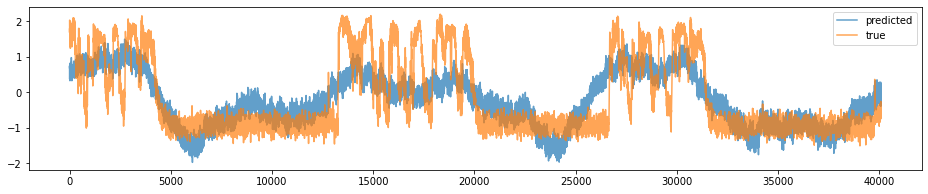

In [20]:
Y_predicted = []
Y_batch = []

model.cuda()

for index, (x_batch, y_batch) in tqdm_notebook(enumerate(data_generator(X_test, Y_test, BATCH_SIZE, LAG_BACKWARD, LAG_FORWARD, shuffle=False, infinite=False))):
    #### Train
    model.eval()
    
    if index < 1000:
        continue  # skip first samples
    
    if index > 1400:
        break # skip all the rest

    x_batch = torch.FloatTensor(x_batch).cuda()
    y_predicted = model(x_batch).cpu().data.numpy()
    assert x_batch.shape[0]==y_predicted.shape[0]
    Y_predicted.append(y_predicted)
    Y_batch.append(y_batch)

Y_predicted = np.concatenate(Y_predicted, axis=0)
Y_batch = np.concatenate(Y_batch, axis=0)

print("Correlation   val", np.corrcoef(Y_predicted[:, 0], Y_batch[:, 0], rowvar=False)[0,1])

plt.figure(figsize=(16, 3))
plt.plot(Y_predicted, label="predicted", alpha=0.7)
plt.plot(Y_batch, label="true", alpha=0.7)
plt.legend()
plt.show()

In [19]:
X_unmixed = []
X_preout = []
Y_predicted = []
Y_batch = []

model.cuda()

for index, (x_batch, y_batch) in tqdm_notebook(enumerate(data_generator(X_test, Y_test, BATCH_SIZE, LAG_BACKWARD, LAG_FORWARD, shuffle=False, infinite=False))):
    #### Train
    model.eval()
    
    if index % 100 != 0:
        continue

    x_batch = torch.FloatTensor(x_batch).cuda()
    y_predicted = model(x_batch).cpu().data.numpy()
    assert x_batch.shape[0]==y_predicted.shape[0]
    Y_predicted.append(y_predicted)
    Y_batch.append(y_batch)
    X_unmixed.append(model.unmixed_channels)
    X_preout.append(model.pre_out)
    

X_unmixed = np.concatenate(X_unmixed, axis=0)
X_unmixed = X_unmixed[:, :, -1]
X_preout = np.concatenate(X_preout, axis=0)
Y_predicted = np.concatenate(Y_predicted, axis=0)
Y_batch = np.concatenate(Y_batch, axis=0)

print("Correlation   val", np.corrcoef(Y_predicted[:, 0], Y_batch[:, 0], rowvar=False)[0,1])

0it [00:00, ?it/s]

/home/pet67/ossadtchi/utils.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  batch_y = Y[[batch_samples]]


Correlation   val 0.6395006816547405


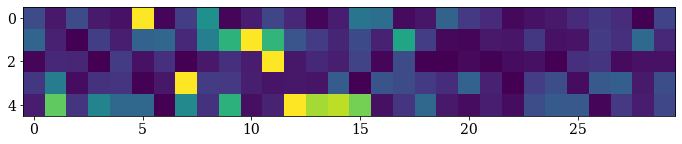

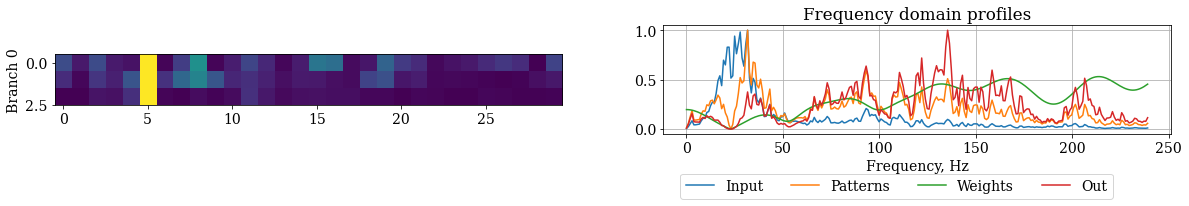

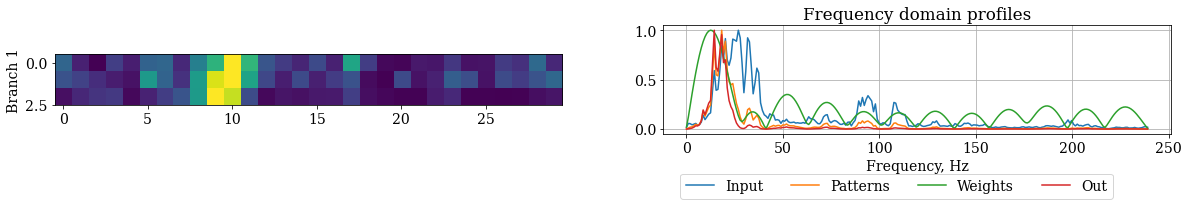

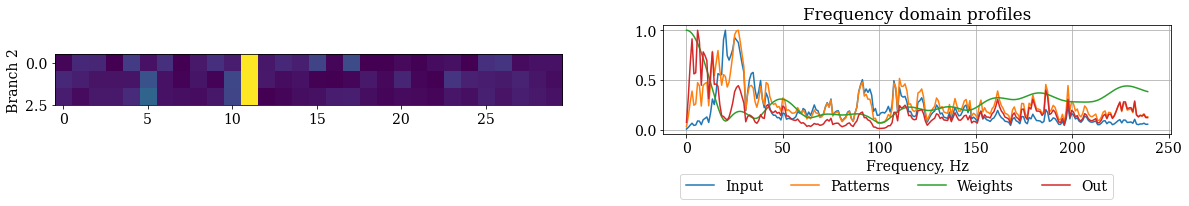

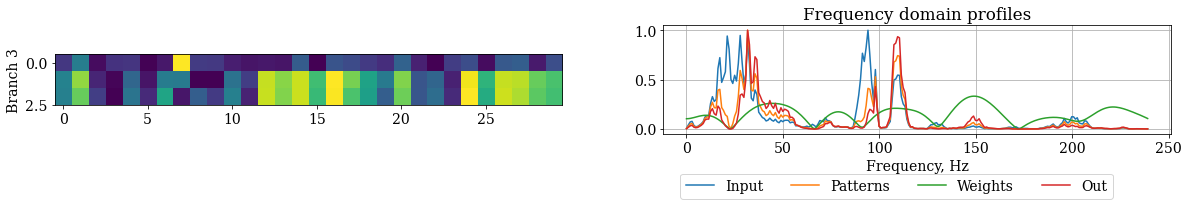

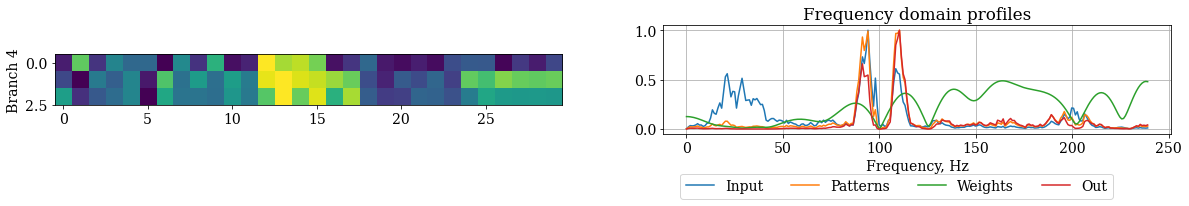

In [20]:
NPERSEQ = 2000

def get_ossagtchi_spatial_patterns(X, temproral_weights, spatial_weights):
    patterns = np.zeros((spatial_weights.shape[0], spatial_weights.shape[1]))
    for i in range(temproral_weights.shape[0]):
        X_filtered = np.zeros(X.shape)
        for j in range(X_filtered.shape[1]):
            X_filtered[:, j] = np.convolve(X[:, j], temproral_weights[i, 0, :], mode="same")
        patterns[:, i] = np.dot(np.cov(X_filtered, rowvar=False), spatial_weights[:, i].reshape((-1, 1)))[:, 0]
    return patterns

def get_interpretable(X, W, Y):
    y_col = Y.shape[1]
    return np.linalg.multi_dot([
        np.cov(X, rowvar=False), 
        W#, 
        #np.linalg.inv(np.cov(Y, rowvar=False).reshape((y_col, y_col)))
    ])


convs_weights = list(model.detector.conv_filtering.cpu().parameters())[0].detach().numpy()

interpret_ossadtchi = get_ossagtchi_spatial_patterns(
    np.copy(X_train[:, :]),
    convs_weights,
    np.repeat(np.copy(model.ica.weight.cpu().detach().numpy()[:, :, 0].transpose()), 1, axis=1),
).reshape(30, model.ICA_CHANNELS, 1)


interpret = get_interpretable(
    np.copy(X_train[:, :]),
    np.copy(model.ica.weight.cpu().detach().numpy()[:, :, 0].transpose()),
    np.copy(X_unmixed)
)

raw_weights = model.ica.weight.cpu().detach().numpy()[:, :, 0].transpose()


####################



COMPARISON_TOLERANCE = 10

ZOOM = 250

def get_freq_domain(signal, frequency):
    n = NPERSEQ
    ampletude = np.abs(np.fft.fft(signal,n))
    frequencies = np.fft.fftfreq(n , 1 / frequency)
    assert len(ampletude) == len(frequencies), f"{len(ampletude)}!={len(frequencies)}"
    end = int(len(frequencies)/2)
    return frequencies[:end], ampletude[:end]

####################

assert interpret_ossadtchi.shape[2] == 1


weights = sklearn.preprocessing.minmax_scale(np.abs(model.ica.weight[:, :, 0].cpu().detach().numpy()).transpose()).transpose()
plt.figure(figsize=(16, 2))
plt.imshow(weights)
plt.show()

# print(sorted(zip(range(30), weights.sum(axis=0)), key=lambda x: x[1], reverse=True))



for i in range(interpret_ossadtchi.shape[1]):
    for j in range(interpret_ossadtchi.shape[2]):
        branches = raw_weights.shape[1]

        FINAL_FUGURE, FINAL_AXIS = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1],'height_ratios': [1]})
        #FINAL_FUGURE.suptitle(nammeee)
        FINAL_FUGURE.set_figwidth(20)
        FINAL_FUGURE.set_figheight(2)
        plt.rc('font', family='serif', size=14)

        plt.rc('ytick', labelsize=14)
        plt.setp(FINAL_AXIS[0], ylabel=f'Branch {i}')
            

        plt.setp(FINAL_AXIS[1], xlabel='Frequency, Hz')

        FINAL_AXIS[1].set_title("Frequency domain profiles")

        weights = convs_weights[i, j, :]
        
        frequencies_input, spectrum_input = scipy.signal.welch(X_unmixed[:, i], FREQUENCY, nperseg=NPERSEQ, detrend='linear')
        frequencies_input = frequencies_input[:-1]
        spectrum_input = spectrum_input[:-1]

        frequencies, ampletude = get_freq_domain(weights, FREQUENCY)

        assert len(frequencies_input) == len(frequencies), f"{len(frequencies_input)}!={len(frequencies)}"
        assert(
            list(np.round(frequencies_input, COMPARISON_TOLERANCE)) ==\
            list(np.round(frequencies, COMPARISON_TOLERANCE))
        )

        recovered = np.power(sklearn.preprocessing.minmax_scale(ampletude), 1) * sklearn.preprocessing.minmax_scale(spectrum_input)
        out_spectrum = np.power(sklearn.preprocessing.minmax_scale(ampletude), 2) * sklearn.preprocessing.minmax_scale(spectrum_input)

        frequencies, ampletude = get_freq_domain(weights, FREQUENCY)
        
        figure = FINAL_AXIS[1]
        
        figure.plot(frequencies_input[:ZOOM], sklearn.preprocessing.minmax_scale(spectrum_input)[:ZOOM], label='Input')
        figure.plot(frequencies[:ZOOM], sklearn.preprocessing.minmax_scale(recovered)[:ZOOM], label='Patterns')
        figure.plot(frequencies[:ZOOM], sklearn.preprocessing.minmax_scale(ampletude)[:ZOOM], label = 'Weights')
        figure.plot(frequencies[:ZOOM], sklearn.preprocessing.minmax_scale(out_spectrum)[:ZOOM], label='Out')
        figure.grid()
        figure.legend(bbox_to_anchor=(0.9, -0.3), ncol=4)
        
        #
        figure = FINAL_AXIS[0]
        figure.imshow(np.array([
            sklearn.preprocessing.minmax_scale(np.abs(raw_weights[:, i]).transpose()),
            sklearn.preprocessing.minmax_scale(np.abs(interpret[:, i]).transpose()),
            sklearn.preprocessing.minmax_scale(np.abs(interpret_ossadtchi[:, i, j]).transpose()),
        ]))


FINAL_FUGURE.show()